In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


# Introduction
This project examines data from a minecraft server with various data collected from the server such as the hours played and the personal information of the players as well as whether they subsribe to a game related newsletter. In this project the question of whether age and hours played is a predictor for whether a player will subscribe to the newsletter was examined. The dataset used to answer this question was players.csv which contains info on whether the player subscribes to the newsletter the name of the players as well as their gender and age, in addition this dataset contained the amount of hours played and the experience level of the players. Of these variables the only ones used for this examination was the hours played the age and whether the player subcribes or not. 

In [2]:
url <- "https://raw.githubusercontent.com/g-amadorz/dsci-project/refs/heads/main/data/players.csv"

players <- read_csv(url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [4]:
players_clean <- players |>
    mutate(age = Age, subscribe = as.factor(subscribe)) |>
    select(age, played_hours, subscribe) |>
    drop_na()

glimpse(players_clean)


Rows: 194
Columns: 3
$ age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


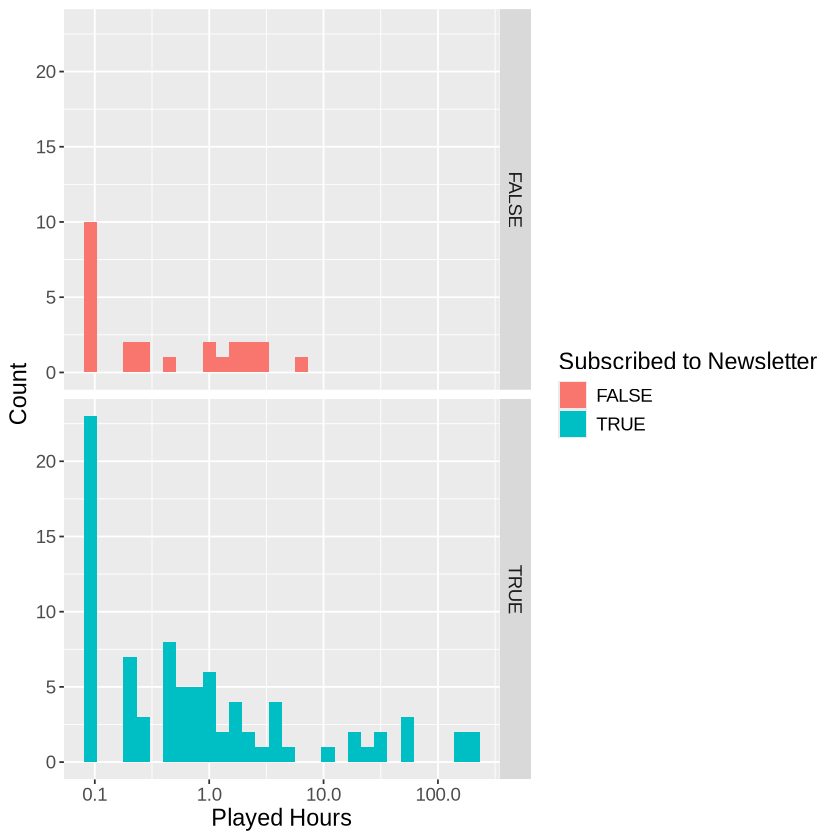

In [5]:
hours_played_hist <- players_clean |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram() +
    scale_x_log10() +
    facet_grid(rows=vars(subscribe)) +
    labs(x = "Played Hours", fill = "Subscribed to Newsletter", y = "Count") +
    theme(text = element_text(size = 14))

hours_played_hist
    

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range
(`stat_density()`).”


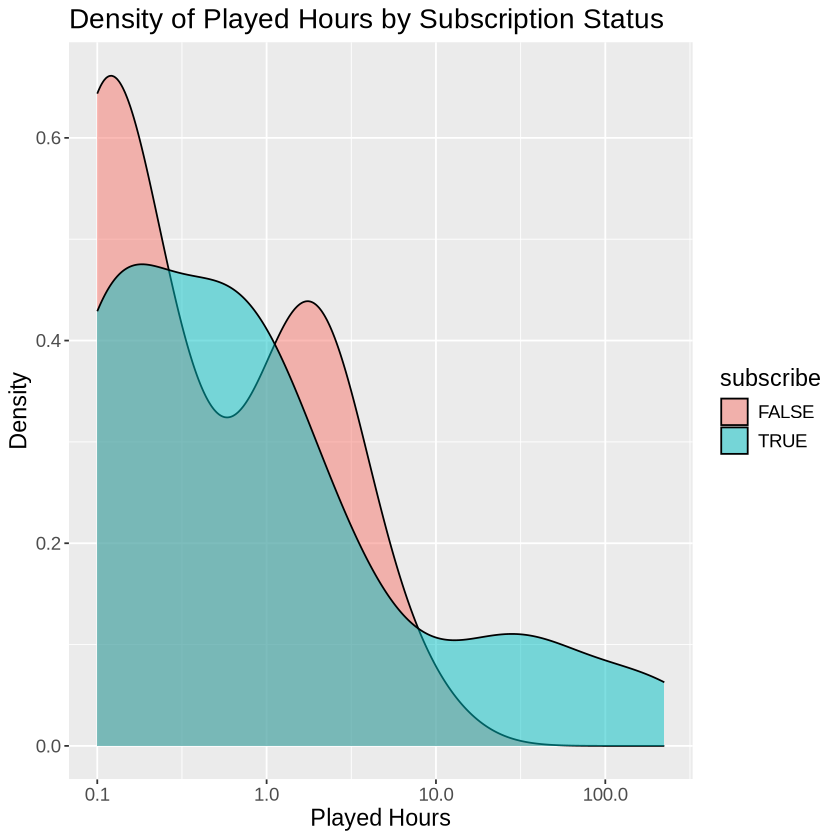

In [6]:
hours_played_density_plot <- players_clean |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_density(alpha = 0.5) +
    scale_x_log10() +
  labs(title = "Density of Played Hours by Subscription Status",
       x = "Played Hours",
       y = "Density") +
    theme(text = element_text(size = 14))

hours_played_density_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


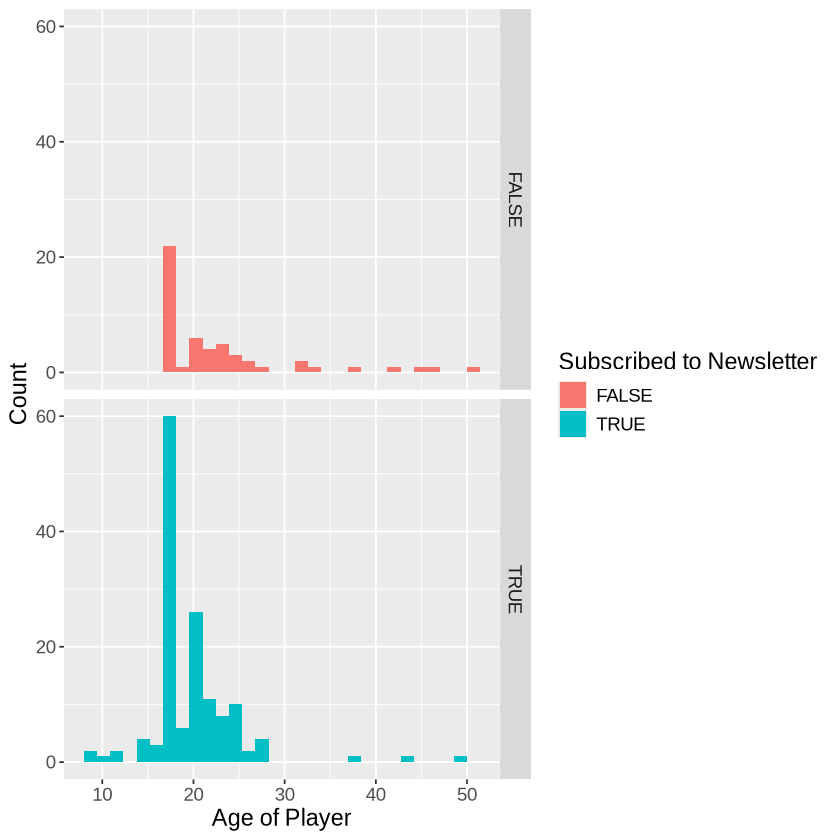

In [23]:
age_hist <- players_clean |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram() +
    facet_grid(rows=vars(subscribe)) +
    labs(x = "Age of Player", fill = "Subscribed to Newsletter", y = "Count") +
    theme(text = element_text(size = 14))

age_hist

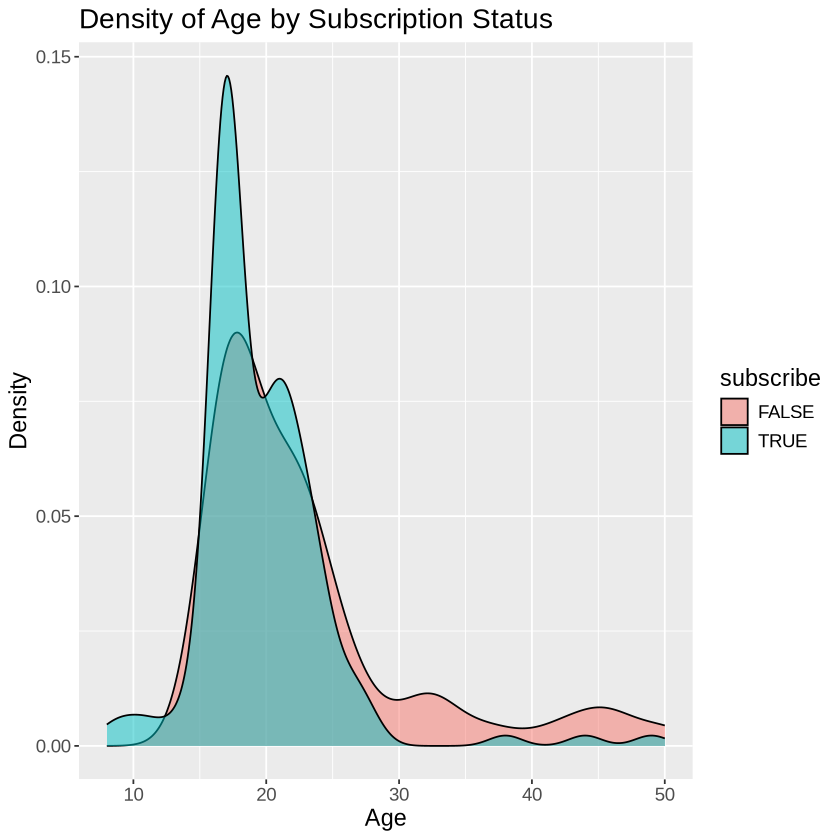

In [22]:
age_density_plot <- players_clean |>
  ggplot(aes(x = age, fill = subscribe)) +
  geom_density(alpha = 0.5) +
  labs(title = "Density of Age by Subscription Status",
       x = "Age",
       y = "Density") +
    theme(text = element_text(size = 14))

age_density_plot

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


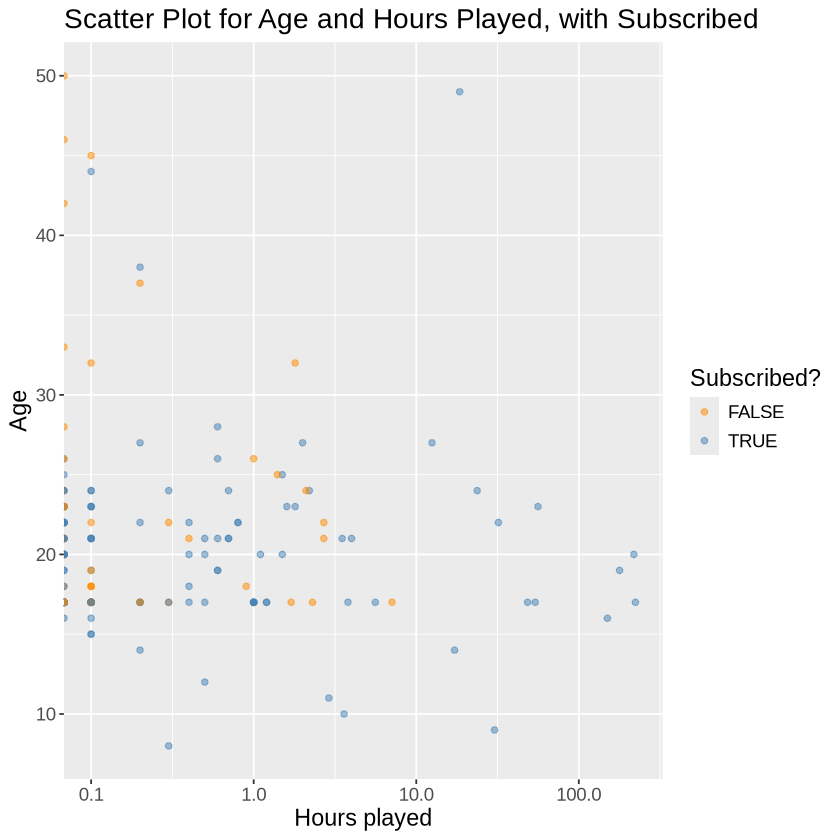

In [7]:
age_hours_scatter_plot <- players_clean |>
    ggplot(aes(x = played_hours, y = age, color = subscribe)) +
    geom_point(alpha=0.5) +
    scale_x_log10()+
    labs(x = "Hours played", 
         y = "Age Of Player", 
         color = "Subscribed?") +
            scale_color_manual(values = c("darkorange", "steelblue")) +
            ggtitle("Scatter Plot for Age and Hours Played, with Subscribed") + 
            theme(text = element_text(size = 14))

age_hours_scatter_plot

**KNN Cross Validation**

In [8]:
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


player_recipe <- recipe(subscribe ~ age + played_hours, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())



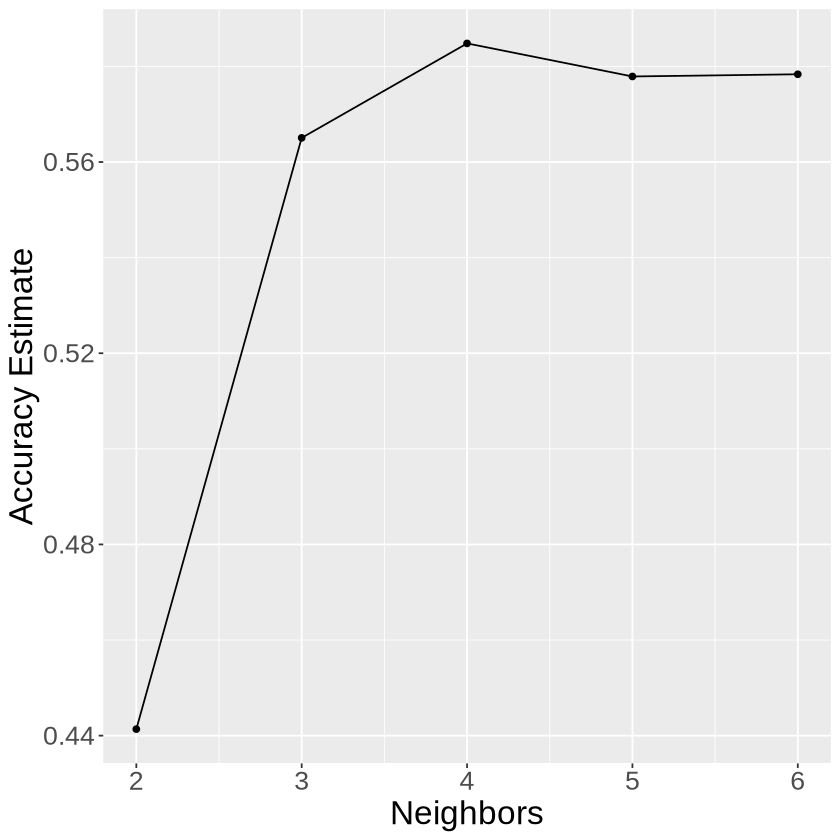

In [15]:
set.seed(123)

players_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
                 add_recipe(player_recipe) |>
                 add_model(player_spec) |>
                 tune_grid(resamples = players_vfold, grid = tibble(neighbors = c(2,3,4,5,6))) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 20))

cross_val_plot

***Players Model***

In [18]:
set.seed(9999)
tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
       set_engine("kknn") |>
       set_mode("classification")

player_fit <- workflow() |>
             add_recipe(player_recipe) |>
             add_model(tuned_spec) |>
            fit(data = player_train)
player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4551724
Best kernel: rectangular
Best k: 4

***Testing Players Model***

In [20]:
player_predictions <- predict(player_fit, player_test) |>
                        bind_cols(player_test)

player_metrics <- player_predictions |> metrics(truth = subscribe, estimate = .pred_class)

player_conf_mat <- player_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
player_metrics
player_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6734694
kap,binary,0.2373541


          Truth
Prediction FALSE TRUE
     FALSE     7   10
     TRUE      6   26

### Notes 

I don't think that age and played_hours are good predicitors for subscription. There is a lot to be desired in the confusion matrix along with the accuracy of the possible K values for the neighbours, out of the 5 chosen, not one was above 60%. The amount of folds chosen was five, which is due to the small sample size of observations.